# Tutorial 02: Model Specification with Formulas

**Series**: PanelBox - Fundamentals
**Level**: Beginner to Intermediate
**Estimated Time**: 50-60 minutes
**Prerequisites**: Tutorial 01 (Introduction to Panel Data Structures)

## Learning Objectives

By the end of this tutorial, you will be able to:
- Understand R-style formula syntax (patsy)
- Specify econometric models using formulas in PanelBox
- Apply transformations within formulas (log, polynomial, interactions)
- Add entity and time fixed effects
- Use advanced formula features (absorbing variables, categorical expansions)
- Translate economic models into PanelBox formulas

## Table of Contents
1. [Why Formulas?](#1-why-formulas)
2. [Basic Formula Syntax](#2-basic-formula-syntax)
3. [Transformations in Formulas](#3-transformations-in-formulas)
4. [Interactions and Polynomials](#4-interactions-and-polynomials)
5. [Fixed Effects in Formulas](#5-fixed-effects-in-formulas)
6. [Advanced Formula Techniques](#6-advanced-formula-techniques)
7. [Practical Exercises](#7-practical-exercises)
8. [Summary and Next Steps](#8-summary-and-next-steps)

---

In [1]:
# Notebook metadata
__version__ = "1.0.0"
__last_updated__ = "2026-02-16"
__compatible_with__ = "PanelBox >= 0.1.0"

# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown

# PanelBox library (development mode)
import sys
sys.path.append('/home/guhaase/projetos/panelbox')
import panelbox as pb
from panelbox.core.panel_data import PanelData

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Display library version
print(f"PanelBox version: {pb.__version__}")
print(f"Notebook version: {__version__}")
print("Setup complete!")

PanelBox version: 1.0.0
Notebook version: 1.0.0
Setup complete!


In [2]:
# Load Grunfeld dataset (same as Tutorial 01)
try:
    from panelbox.datasets import load_grunfeld
    data = load_grunfeld()
    print("✓ Loaded from panelbox.datasets.load_grunfeld()")
except ImportError:
    import os
    data_path = '/home/guhaase/projetos/panelbox/examples/datasets/grunfeld.csv'
    if os.path.exists(data_path):
        data = pd.read_csv(data_path)
        print(f"✓ Loaded from {data_path}")
    else:
        data_path = '/home/guhaase/projetos/panelbox/panelbox/datasets/grunfeld.csv'
        data = pd.read_csv(data_path)
        print(f"✓ Loaded from {data_path}")

# Quick recap of the data
print(f"\nDataset: Grunfeld Investment Data")
print(f"Observations: {data.shape[0]}")
print(f"Variables: {list(data.columns)}")
print("\nFirst few rows:")
display(data.head())

✓ Loaded from panelbox.datasets.load_grunfeld()

Dataset: Grunfeld Investment Data
Observations: 200
Variables: ['firm', 'year', 'invest', 'value', 'capital']

First few rows:


,firm,year,invest,value,capital
0,1,1935,317.6,3078.5,2.8
1,1,1936,391.8,4661.7,52.6
2,1,1937,410.6,5387.1,156.9
3,1,1938,257.7,2792.2,209.2
4,1,1939,330.8,4313.2,203.4


## 1. Why Formulas?

### The Problem: Specifying Econometric Models

Consider the classic investment equation:
$$
\text{Investment}_{it} = \beta_0 + \beta_1 \text{Value}_{it} + \beta_2 \text{Capital}_{it} + \varepsilon_{it}
$$

**Traditional approach** (manual matrix construction):
```python
# Create design matrix manually
y = data['invest']
X = data[['value', 'capital']]
X['intercept'] = 1
```

Problems:
- ❌ Tedious for complex models
- ❌ Error-prone (forget intercept, transformations)
- ❌ Hard to read (what model is this?)
- ❌ Difficult to modify (add interaction? polynomial?)

---

### The Solution: Formula Syntax

**PanelBox approach** (R-style formulas):
```python
formula = "invest ~ value + capital"
```

Advantages:
- ✅ **Readable**: Directly maps to econometric notation
- ✅ **Concise**: One line vs multiple
- ✅ **Flexible**: Easy to add transformations, interactions
- ✅ **Standard**: Same syntax as R, statsmodels, linearmodels

### Inspiration: R and Patsy

PanelBox uses **patsy** (Python implementation of R formulas):
- `y ~ x`: Regress y on x (includes intercept automatically)
- `y ~ x - 1`: Exclude intercept
- `y ~ x + I(x**2)`: Add polynomial
- `y ~ x * z`: Add x, z, and their interaction

---

In [3]:
# Compare manual vs formula approach
print("="*60)
print("MANUAL vs FORMULA APPROACH")
print("="*60)

# Manual approach
y_manual = data['invest']
X_manual = data[['value', 'capital']].copy()
X_manual.insert(0, 'intercept', 1)

print("\n1. MANUAL APPROACH")
print(f"   y shape: {y_manual.shape}")
print(f"   X shape: {X_manual.shape}")
print(f"   X columns: {list(X_manual.columns)}")

# Formula approach (demonstration - actual model fit comes in Tutorial 03)
formula = "invest ~ value + capital"

print("\n2. FORMULA APPROACH")
print(f"   Formula: '{formula}'")
print(f"   Interpretation: invest = β₀ + β₁·value + β₂·capital + ε")
print(f"   Design matrix created automatically (includes intercept)")

print("\n✓ Same model, much simpler specification!")

MANUAL vs FORMULA APPROACH

1. MANUAL APPROACH
   y shape: (200,)
   X shape: (200, 3)
   X columns: ['intercept', 'value', 'capital']

2. FORMULA APPROACH
   Formula: 'invest ~ value + capital'
   Interpretation: invest = β₀ + β₁·value + β₂·capital + ε
   Design matrix created automatically (includes intercept)

✓ Same model, much simpler specification!


## 2. Basic Formula Syntax

### General Structure

```
dependent_variable ~ independent_variables
```

**Left side** (LHS): Outcome variable
**Right side** (RHS): Predictors

### Operators

| Operator | Meaning | Example | Equivalent Model |
|----------|---------|---------|------------------|
| `+` | Add predictor | `y ~ x + z` | $y = \beta_0 + \beta_1 x + \beta_2 z + \varepsilon$ |
| `-` | Remove term | `y ~ x - 1` | $y = \beta_1 x + \varepsilon$ (no intercept) |
| `:` | Interaction only | `y ~ x:z` | $y = \beta_0 + \beta_1 (x \times z) + \varepsilon$ |
| `*` | Main effects + interaction | `y ~ x*z` | $y = \beta_0 + \beta_1 x + \beta_2 z + \beta_3 (x \times z) + \varepsilon$ |
| `I()` | Identity (protect expression) | `y ~ I(x**2)` | $y = \beta_0 + \beta_1 x^2 + \varepsilon$ |
| `C()` | Categorical (factor) | `y ~ C(group)` | Dummy variables for group |

---

In [4]:
# Demonstrate basic formula syntax
from patsy import dmatrix, dmatrices

print("="*60)
print("BASIC FORMULA EXAMPLES")
print("="*60)

# Example 1: Simple regression
formula1 = "invest ~ value"
print(f"\n1. Simple Regression: '{formula1}'")
print(f"   Model: invest = β₀ + β₁·value + ε")

# Example 2: Multiple regression
formula2 = "invest ~ value + capital"
print(f"\n2. Multiple Regression: '{formula2}'")
print(f"   Model: invest = β₀ + β₁·value + β₂·capital + ε")

# Example 3: No intercept
formula3 = "invest ~ value + capital - 1"
print(f"\n3. No Intercept: '{formula3}'")
print(f"   Model: invest = β₁·value + β₂·capital + ε")

# Create design matrix for formula2 to show structure
y, X = dmatrices(formula2, data=data, return_type='dataframe')
print(f"\n4. Design Matrix for '{formula2}':")
print(f"   X shape: {X.shape}")
print(f"   X columns: {list(X.columns)}")
print("\n   First 5 rows of X:")
display(X.head())

BASIC FORMULA EXAMPLES

1. Simple Regression: 'invest ~ value'
   Model: invest = β₀ + β₁·value + ε

2. Multiple Regression: 'invest ~ value + capital'
   Model: invest = β₀ + β₁·value + β₂·capital + ε

3. No Intercept: 'invest ~ value + capital - 1'
   Model: invest = β₁·value + β₂·capital + ε

4. Design Matrix for 'invest ~ value + capital':
   X shape: (200, 3)
   X columns: ['Intercept', 'value', 'capital']

   First 5 rows of X:


,Intercept,value,capital
0,1.0,3078.5,2.8
1,1.0,4661.7,52.6
2,1.0,5387.1,156.9
3,1.0,2792.2,209.2
4,1.0,4313.2,203.4


## 3. Transformations in Formulas

### Why Transform Variables?

Economic theory often suggests nonlinear relationships:
- **Log-linear models**: Elasticities (e.g., Cobb-Douglas production)
- **Polynomial models**: Diminishing returns, U-shaped curves
- **Standardization**: Compare coefficients across scales

### Common Transformations

| Transformation | Syntax | Interpretation |
|----------------|--------|----------------|
| Logarithm | `np.log(x)` | % change in y per % change in x (elasticity) |
| Square root | `np.sqrt(x)` | Compress large values |
| Polynomial | `I(x**2)` | Quadratic, cubic relationships |
| Inverse | `I(1/x)` | Hyperbolic decay |
| Standardization | `(x - x.mean())/x.std()` | Z-scores (mean 0, std 1) |

**Important**: Use `I()` to protect mathematical expressions!

Example:
- ❌ `y ~ x**2` (will fail - patsy interprets `**` specially)
- ✅ `y ~ I(x**2)` (correct - `I()` protects the expression)

---

In [5]:
# Log transformations
print("="*60)
print("LOGARITHMIC TRANSFORMATIONS")
print("="*60)

# Log-linear model
formula_log_linear = "np.log(invest) ~ value + capital"
print(f"\n1. Log-Linear Model: '{formula_log_linear}'")
print(f"   Model: log(invest) = β₀ + β₁·value + β₂·capital + ε")
print(f"   Interpretation: β₁ = semi-elasticity (% change in invest per unit change in value)")

# Log-log model (elasticities)
formula_log_log = "np.log(invest) ~ np.log(value) + np.log(capital)"
print(f"\n2. Log-Log Model (Double-Log): '{formula_log_log}'")
print(f"   Model: log(invest) = β₀ + β₁·log(value) + β₂·log(capital) + ε")
print(f"   Interpretation: β₁, β₂ = elasticities (% change in invest per % change in predictor)")
print(f"   Example: If β₁ = 0.8, a 10% increase in value → 8% increase in investment")

# Create design matrix
y_log, X_log = dmatrices(formula_log_log, data=data, return_type='dataframe')
print(f"\n3. Design Matrix for Log-Log Model:")
print(f"   y (dependent): {y_log.columns[0]}")
print(f"   X (predictors): {list(X_log.columns)}")
print("\n   First 5 rows:")
display(pd.concat([y_log.head(), X_log.head()], axis=1))

LOGARITHMIC TRANSFORMATIONS

1. Log-Linear Model: 'np.log(invest) ~ value + capital'
   Model: log(invest) = β₀ + β₁·value + β₂·capital + ε
   Interpretation: β₁ = semi-elasticity (% change in invest per unit change in value)

2. Log-Log Model (Double-Log): 'np.log(invest) ~ np.log(value) + np.log(capital)'
   Model: log(invest) = β₀ + β₁·log(value) + β₂·log(capital) + ε
   Interpretation: β₁, β₂ = elasticities (% change in invest per % change in predictor)
   Example: If β₁ = 0.8, a 10% increase in value → 8% increase in investment

3. Design Matrix for Log-Log Model:
   y (dependent): np.log(invest)
   X (predictors): ['Intercept', 'np.log(value)', 'np.log(capital)']

   First 5 rows:


,np.log(invest),Intercept,np.log(value),np.log(capital)
0,5.7608,1.0,8.0322,1.0296
1,5.9708,1.0,8.4471,3.9627
2,6.0176,1.0,8.5918,5.0556
3,5.5518,1.0,7.9346,5.3433
4,5.8015,1.0,8.3694,5.3152



POLYNOMIAL TRANSFORMATIONS

1. Quadratic Model: 'invest ~ value + I(value**2) + capital'
   Model: invest = β₀ + β₁·value + β₂·value² + β₃·capital + ε
   Interpretation: Allows for nonlinear (U-shaped or inverted-U) relationship
   Example: Marginal effect of value = β₁ + 2·β₂·value (depends on value level)

2. Design Matrix:
   X columns: ['Intercept', 'value', 'I(value ** 2)', 'capital']

   First 5 rows:


,Intercept,value,I(value ** 2),capital
0,1.0,3078.5,9.4772e+06,2.8
1,1.0,4661.7,2.1731e+07,52.6
2,1.0,5387.1,2.9021e+07,156.9
3,1.0,2792.2,7.7964e+06,209.2
4,1.0,4313.2,1.8604e+07,203.4


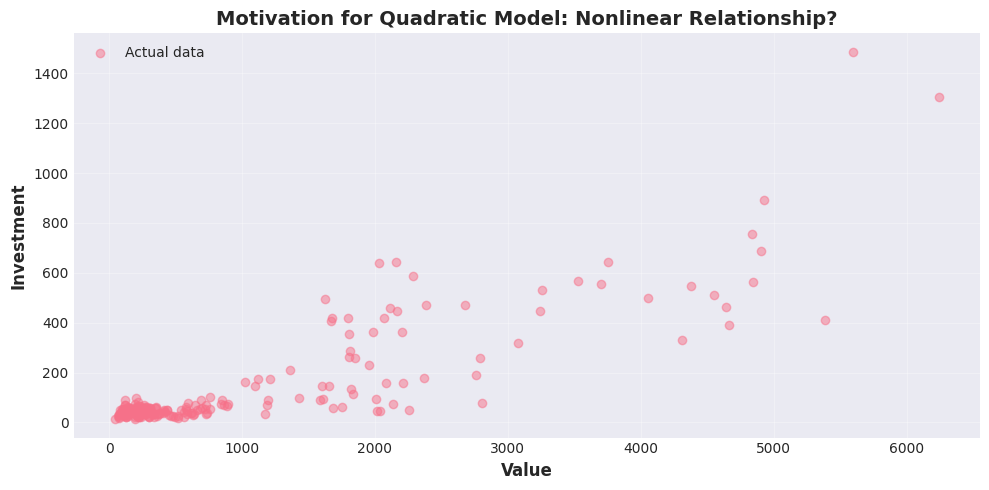


Note: Visual inspection suggests potential nonlinearity


In [6]:
# Polynomial transformations
print("\n" + "="*60)
print("POLYNOMIAL TRANSFORMATIONS")
print("="*60)

# Quadratic model
formula_quad = "invest ~ value + I(value**2) + capital"
print(f"\n1. Quadratic Model: '{formula_quad}'")
print(f"   Model: invest = β₀ + β₁·value + β₂·value² + β₃·capital + ε")
print(f"   Interpretation: Allows for nonlinear (U-shaped or inverted-U) relationship")
print(f"   Example: Marginal effect of value = β₁ + 2·β₂·value (depends on value level)")

# Create design matrix
y_quad, X_quad = dmatrices(formula_quad, data=data, return_type='dataframe')
print(f"\n2. Design Matrix:")
print(f"   X columns: {list(X_quad.columns)}")
print("\n   First 5 rows:")
display(X_quad.head())

# Visualize quadratic relationship
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(data['value'], data['invest'], alpha=0.5, label='Actual data')
ax.set_xlabel('Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Investment', fontsize=12, fontweight='bold')
ax.set_title('Motivation for Quadratic Model: Nonlinear Relationship?', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNote: Visual inspection suggests potential nonlinearity")

In [7]:
# Custom transformations
print("\n" + "="*60)
print("CUSTOM TRANSFORMATIONS")
print("="*60)

# Create transformed variable in DataFrame
data['value_squared'] = data['value']**2
data['log_capital'] = np.log(data['capital'])

# Use in formula
formula_custom = "invest ~ value + value_squared + log_capital"
print(f"\n1. Using Pre-Transformed Variables: '{formula_custom}'")
print(f"   Alternative to: 'invest ~ value + I(value**2) + np.log(capital)'")
print(f"   Advantage: Cleaner formula, can reuse transformation")

# Standardization
data['value_std'] = (data['value'] - data['value'].mean()) / data['value'].std()

formula_std = "invest ~ value_std + capital"
print(f"\n2. Standardized Variables: '{formula_std}'")
print(f"   value_std has mean=0, std=1")
print(f"   Interpretation: β₁ = change in invest per 1 SD increase in value")

print(f"\n3. Verification:")
print(f"   Mean of value_std: {data['value_std'].mean():.6f} (≈ 0)")
print(f"   Std of value_std: {data['value_std'].std():.6f} (≈ 1)")


CUSTOM TRANSFORMATIONS

1. Using Pre-Transformed Variables: 'invest ~ value + value_squared + log_capital'
   Alternative to: 'invest ~ value + I(value**2) + np.log(capital)'
   Advantage: Cleaner formula, can reuse transformation

2. Standardized Variables: 'invest ~ value_std + capital'
   value_std has mean=0, std=1
   Interpretation: β₁ = change in invest per 1 SD increase in value

3. Verification:
   Mean of value_std: 0.000000 (≈ 0)
   Std of value_std: 1.000000 (≈ 1)


## 4. Interactions and Polynomials

### Interaction Terms

An **interaction** captures how the effect of one variable depends on another.

Economic example: Effect of firm value on investment may depend on capital stock.
$$
\text{Investment}_{it} = \beta_0 + \beta_1 \text{Value}_{it} + \beta_2 \text{Capital}_{it} + \beta_3 (\text{Value}_{it} \times \text{Capital}_{it}) + \varepsilon_{it}
$$

**Marginal effect of Value**:
$$
\frac{\partial \text{Investment}}{\partial \text{Value}} = \beta_1 + \beta_3 \cdot \text{Capital}
$$

The effect of value is $\beta_1$ when capital=0, but changes by $\beta_3$ for each unit increase in capital.

### Syntax

- `x:z` → Interaction only (no main effects)
- `x*z` → Equivalent to `x + z + x:z` (main effects + interaction)

---

In [8]:
# Interaction terms
print("="*60)
print("INTERACTION TERMS")
print("="*60)

# Interaction only
formula_int_only = "invest ~ value:capital"
print(f"\n1. Interaction Only: '{formula_int_only}'")
print(f"   Model: invest = β₀ + β₁·(value × capital) + ε")
print(f"   Note: No main effects of value or capital")

# Full interaction (main effects + interaction)
formula_int_full = "invest ~ value * capital"
print(f"\n2. Full Interaction: '{formula_int_full}'")
print(f"   Expands to: 'invest ~ value + capital + value:capital'")
print(f"   Model: invest = β₀ + β₁·value + β₂·capital + β₃·(value × capital) + ε")

# Create design matrix
y_int, X_int = dmatrices(formula_int_full, data=data, return_type='dataframe')
print(f"\n3. Design Matrix:")
print(f"   X columns: {list(X_int.columns)}")
print("\n   First 5 rows:")
display(X_int.head())

# Verify interaction is product
print(f"\n4. Verification (interaction = value × capital):")
sample_idx = 0
value_sample = data['value'].iloc[sample_idx]
capital_sample = data['capital'].iloc[sample_idx]
interaction_manual = value_sample * capital_sample
interaction_patsy = X_int['value:capital'].iloc[sample_idx]
print(f"   value[{sample_idx}] = {value_sample:.4f}")
print(f"   capital[{sample_idx}] = {capital_sample:.4f}")
print(f"   value × capital = {interaction_manual:.4f}")
print(f"   Patsy interaction = {interaction_patsy:.4f}")
print(f"   Match: {np.isclose(interaction_manual, interaction_patsy)}")

INTERACTION TERMS

1. Interaction Only: 'invest ~ value:capital'
   Model: invest = β₀ + β₁·(value × capital) + ε
   Note: No main effects of value or capital

2. Full Interaction: 'invest ~ value * capital'
   Expands to: 'invest ~ value + capital + value:capital'
   Model: invest = β₀ + β₁·value + β₂·capital + β₃·(value × capital) + ε

3. Design Matrix:
   X columns: ['Intercept', 'value', 'capital', 'value:capital']

   First 5 rows:


,Intercept,value,capital,value:capital
0,1.0,3078.5,2.8,8619.80
1,1.0,4661.7,52.6,245205.42
2,1.0,5387.1,156.9,845235.99
3,1.0,2792.2,209.2,584128.24
4,1.0,4313.2,203.4,877304.88



4. Verification (interaction = value × capital):
   value[0] = 3078.5000
   capital[0] = 2.8000
   value × capital = 8619.8000
   Patsy interaction = 8619.8000
   Match: True


In [9]:
# Three-way interactions
print("\n" + "="*60)
print("HIGHER-ORDER INTERACTIONS")
print("="*60)

# Add a third variable (create dummy for demonstration)
data['post_1945'] = (data['year'] > 1945).astype(int)

# Three-way interaction
formula_3way = "invest ~ value * capital * post_1945"
print(f"\n1. Three-Way Interaction: '{formula_3way}'")
print(f"   Expands to: All combinations of value, capital, post_1945")
print(f"   Total terms: 2³ = 8 (main effects, 2-way, 3-way)")

# Create design matrix
y_3way, X_3way = dmatrices(formula_3way, data=data, return_type='dataframe')
print(f"\n2. Design Matrix:")
print(f"   X shape: {X_3way.shape}")
print(f"   X columns: {list(X_3way.columns)}")

print("\n   Interpretation:")
print("   - Main effects: value, capital, post_1945")
print("   - 2-way: value:capital, value:post_1945, capital:post_1945")
print("   - 3-way: value:capital:post_1945")


HIGHER-ORDER INTERACTIONS

1. Three-Way Interaction: 'invest ~ value * capital * post_1945'
   Expands to: All combinations of value, capital, post_1945
   Total terms: 2³ = 8 (main effects, 2-way, 3-way)

2. Design Matrix:
   X shape: (200, 8)
   X columns: ['Intercept', 'value', 'capital', 'value:capital', 'post_1945', 'value:post_1945', 'capital:post_1945', 'value:capital:post_1945']

   Interpretation:
   - Main effects: value, capital, post_1945
   - 2-way: value:capital, value:post_1945, capital:post_1945
   - 3-way: value:capital:post_1945


## 5. Fixed Effects in Formulas

### What are Fixed Effects?

**Entity fixed effects** ($\alpha_i$): Control for time-invariant entity characteristics
$$
Y_{it} = \beta X_{it} + \alpha_i + \varepsilon_{it}
$$

**Time fixed effects** ($\lambda_t$): Control for common time shocks
$$
Y_{it} = \beta X_{it} + \lambda_t + \varepsilon_{it}
$$

**Two-way fixed effects**: Control for both
$$
Y_{it} = \beta X_{it} + \alpha_i + \lambda_t + \varepsilon_{it}
$$

### Why Use Fixed Effects?

✅ **Remove omitted variable bias**: From unobserved, time-invariant factors
✅ **Control for heterogeneity**: Firm culture, country institutions, etc.
✅ **Identify causal effects**: Under strict exogeneity assumption

### Implementation in PanelBox

**Option 1**: Use categorical variable in formula
```python
formula = "invest ~ value + capital + C(firm)"
```

**Option 2**: Use dedicated fixed effects estimator (Tutorial 03)
```python
from panelbox.models import FixedEffects
model = FixedEffects("invest ~ value + capital", data, entity_col='firm')
```

---

In [10]:
# Entity fixed effects in formulas
print("="*60)
print("ENTITY FIXED EFFECTS")
print("="*60)

# Entity FE via categorical variable
formula_entity_fe = "invest ~ value + capital + C(firm)"
print(f"\n1. Entity Fixed Effects: '{formula_entity_fe}'")
print(f"   Model: invest = β₁·value + β₂·capital + α_firm + ε")
print(f"   C(firm) creates dummy variables for each firm (omits one reference)")

# Create design matrix
# Note: Use a subset for display (full matrix has many firm dummies)
y_fe, X_fe = dmatrices(formula_entity_fe, data=data, return_type='dataframe')
print(f"\n2. Design Matrix:")
print(f"   X shape: {X_fe.shape}")
print(f"   X columns (first 10): {list(X_fe.columns[:10])}")
print(f"   Total columns: {X_fe.shape[1]} = Intercept + 2 vars + {X_fe.shape[1]-3} firm dummies")

print("\n   First 5 rows (selected columns):")
display(X_fe[['Intercept', 'value', 'capital']].head())

print("\n3. Interpretation:")
print(f"   - {X_fe.shape[1]-3} firm dummies (out of {data['firm'].nunique()} firms)")
print(f"   - One firm is reference category (absorbed in intercept)")
print(f"   - Each dummy = deviation of that firm's intercept from reference")

ENTITY FIXED EFFECTS

1. Entity Fixed Effects: 'invest ~ value + capital + C(firm)'
   Model: invest = β₁·value + β₂·capital + α_firm + ε
   C(firm) creates dummy variables for each firm (omits one reference)

2. Design Matrix:
   X shape: (200, 12)
   X columns (first 10): ['Intercept', 'C(firm)[T.2]', 'C(firm)[T.3]', 'C(firm)[T.4]', 'C(firm)[T.5]', 'C(firm)[T.6]', 'C(firm)[T.7]', 'C(firm)[T.8]', 'C(firm)[T.9]', 'C(firm)[T.10]']
   Total columns: 12 = Intercept + 2 vars + 9 firm dummies

   First 5 rows (selected columns):


,Intercept,value,capital
0,1.0,3078.5,2.8
1,1.0,4661.7,52.6
2,1.0,5387.1,156.9
3,1.0,2792.2,209.2
4,1.0,4313.2,203.4



3. Interpretation:
   - 9 firm dummies (out of 10 firms)
   - One firm is reference category (absorbed in intercept)
   - Each dummy = deviation of that firm's intercept from reference


In [11]:
# Time fixed effects
print("\n" + "="*60)
print("TIME FIXED EFFECTS")
print("="*60)

formula_time_fe = "invest ~ value + capital + C(year)"
print(f"\n1. Time Fixed Effects: '{formula_time_fe}'")
print(f"   Model: invest = β₁·value + β₂·capital + λ_year + ε")
print(f"   C(year) creates dummy variables for each year (omits one reference)")

y_tfe, X_tfe = dmatrices(formula_time_fe, data=data, return_type='dataframe')
print(f"\n2. Design Matrix:")
print(f"   X shape: {X_tfe.shape}")
print(f"   Total columns: {X_tfe.shape[1]} = Intercept + 2 vars + {X_tfe.shape[1]-3} year dummies")

print("\n3. Interpretation:")
print(f"   - Controls for aggregate shocks affecting all firms in each year")
print(f"   - Examples: Recessions, policy changes, interest rate shocks")


TIME FIXED EFFECTS

1. Time Fixed Effects: 'invest ~ value + capital + C(year)'
   Model: invest = β₁·value + β₂·capital + λ_year + ε
   C(year) creates dummy variables for each year (omits one reference)

2. Design Matrix:
   X shape: (200, 22)
   Total columns: 22 = Intercept + 2 vars + 19 year dummies

3. Interpretation:
   - Controls for aggregate shocks affecting all firms in each year
   - Examples: Recessions, policy changes, interest rate shocks


In [12]:
# Two-way fixed effects
print("\n" + "="*60)
print("TWO-WAY FIXED EFFECTS")
print("="*60)

formula_twoway_fe = "invest ~ value + capital + C(firm) + C(year)"
print(f"\n1. Two-Way Fixed Effects: '{formula_twoway_fe}'")
print(f"   Model: invest = β₁·value + β₂·capital + α_firm + λ_year + ε")
print(f"   Controls for both entity and time unobserved heterogeneity")

y_twfe, X_twfe = dmatrices(formula_twoway_fe, data=data, return_type='dataframe')
print(f"\n2. Design Matrix:")
print(f"   X shape: {X_twfe.shape}")
num_firm_dummies = data['firm'].nunique() - 1
num_year_dummies = data['year'].nunique() - 1
print(f"   Firm dummies: {num_firm_dummies}")
print(f"   Year dummies: {num_year_dummies}")
print(f"   Total: Intercept + 2 vars + {num_firm_dummies} + {num_year_dummies} = {X_twfe.shape[1]} columns")

print("\n3. Note:")
print("   Two-way FE is common in difference-in-differences (DiD) designs")
print("   Absorbs both time-invariant firm traits and common time shocks")


TWO-WAY FIXED EFFECTS

1. Two-Way Fixed Effects: 'invest ~ value + capital + C(firm) + C(year)'
   Model: invest = β₁·value + β₂·capital + α_firm + λ_year + ε
   Controls for both entity and time unobserved heterogeneity

2. Design Matrix:
   X shape: (200, 31)
   Firm dummies: 9
   Year dummies: 19
   Total: Intercept + 2 vars + 9 + 19 = 31 columns

3. Note:
   Two-way FE is common in difference-in-differences (DiD) designs
   Absorbs both time-invariant firm traits and common time shocks


## 6. Advanced Formula Techniques

### Absorbing Variables (High-Dimensional FE)

When you have many fixed effects (e.g., 1000s of firms), including dummies is inefficient:
- Large design matrix
- Slow estimation
- Multicollinearity

**Solution**: Use `absorb` parameter in PanelBox models (not in formula)
```python
# Instead of: "y ~ x + C(firm) + C(year)"
# Use:
model = FixedEffects("y ~ x", data, entity_effects=True, time_effects=True)
```

This **absorbs** (demeans) the fixed effects without creating dummies.

---

### Categorical Variable Coding

By default, `C(var)` uses **treatment coding** (drop first category as reference).

**Alternatives** (advanced):
```python
C(var, Treatment)  # Default: drop first
C(var, Sum)        # Sum-to-zero contrasts
C(var, Helmert)    # Orthogonal contrasts
```

Rarely needed in econometrics; treatment coding is standard.

---

### Excluding Intercept Strategically

**When to drop intercept** (`-1` or `+0`):
- Including all levels of a categorical without reference
- Fitting model through origin (rare in economics)

Example:
```python
"y ~ C(firm) - 1"  # Includes dummy for EVERY firm (no reference)
```

---

In [13]:
# Understanding how formulas are parsed
from patsy import ModelDesc

print("="*60)
print("FORMULA PARSING")
print("="*60)

formula = "invest ~ np.log(value) + I(capital**2) + value:capital"

# Parse the formula
desc = ModelDesc.from_formula(formula)

print(f"\nFormula: '{formula}'")
print(f"\nParsed components:")
print(f"  LHS (dependent): {desc.lhs_termlist}")
print(f"  RHS (predictors): {desc.rhs_termlist}")

print(f"\nInterpretation:")
print(f"  - Intercept: Added automatically (unless '-1')")
print(f"  - np.log(value): Log transformation")
print(f"  - I(capital**2): Squared capital (protected by I())")
print(f"  - value:capital: Interaction")

FORMULA PARSING

Formula: 'invest ~ np.log(value) + I(capital**2) + value:capital'

Parsed components:
  LHS (dependent): [Term([EvalFactor('invest')])]
  RHS (predictors): [Term([]), Term([EvalFactor('np.log(value)')]), Term([EvalFactor('I(capital ** 2)')]), Term([EvalFactor('value'), EvalFactor('capital')])]

Interpretation:
  - Intercept: Added automatically (unless '-1')
  - np.log(value): Log transformation
  - I(capital**2): Squared capital (protected by I())
  - value:capital: Interaction


### Tips and Best Practices

1. **Always check the design matrix**: Use `dmatrices()` to verify
2. **Use `I()` for math**: Protect expressions like `x**2`, `x/y`, `x-y`
3. **Pre-transform if complex**: Create variables in DataFrame for complicated transforms
4. **Document formulas**: Add comments explaining economic interpretation
5. **Watch for collinearity**: Too many interactions can cause multicollinearity

---

In [14]:
# Common pitfalls
print("="*60)
print("COMMON PITFALLS")
print("="*60)

print("\n1. Forgetting I() for math:")
print("   ❌ 'y ~ x**2' → ERROR (patsy doesn't understand **)")
print("   ✅ 'y ~ I(x**2)' → Correct")

print("\n2. Confusion with -:")
print("   'y ~ x - 1' → Remove intercept")
print("   'y ~ x - z' → Remove variable z (rarely used)")

print("\n3. Interaction without main effects:")
print("   'y ~ x:z' → Only interaction (unusual)")
print("   'y ~ x*z' → Main effects + interaction (standard)")

print("\n4. Categorical without C():")
print("   If 'firm' is numeric (1, 2, 3...), formula treats it as continuous!")
print("   ✅ Use C(firm) to explicitly declare categorical")

# Demonstrate categorical issue
data_demo = data.copy()
data_demo['firm_num'] = data_demo['firm'].astype('category').cat.codes

formula_wrong = "invest ~ firm_num"  # Treats firm as continuous!
formula_right = "invest ~ C(firm_num)"  # Treats firm as categorical

y_wrong, X_wrong = dmatrices(formula_wrong, data=data_demo, return_type='dataframe')
y_right, X_right = dmatrices(formula_right, data=data_demo, return_type='dataframe')

print(f"\n5. Example:")
print(f"   Formula: '{formula_wrong}' → X shape: {X_wrong.shape} (firm as continuous)")
print(f"   Formula: '{formula_right}' → X shape: {X_right.shape} (firm as categorical)")

COMMON PITFALLS

1. Forgetting I() for math:
   ❌ 'y ~ x**2' → ERROR (patsy doesn't understand **)
   ✅ 'y ~ I(x**2)' → Correct

2. Confusion with -:
   'y ~ x - 1' → Remove intercept
   'y ~ x - z' → Remove variable z (rarely used)

3. Interaction without main effects:
   'y ~ x:z' → Only interaction (unusual)
   'y ~ x*z' → Main effects + interaction (standard)

4. Categorical without C():
   If 'firm' is numeric (1, 2, 3...), formula treats it as continuous!
   ✅ Use C(firm) to explicitly declare categorical

5. Example:
   Formula: 'invest ~ firm_num' → X shape: (200, 2) (firm as continuous)
   Formula: 'invest ~ C(firm_num)' → X shape: (200, 10) (firm as categorical)


## 7. Practical Exercises

Test your formula skills! Solutions in `/solutions/01_fundamentals/02_formulas_solutions.ipynb`.

### Exercise 1: Log-Log Model

**Task**: Specify a log-log model (Cobb-Douglas style):
$$
\log(\text{Investment}_{it}) = \beta_0 + \beta_1 \log(\text{Value}_{it}) + \beta_2 \log(\text{Capital}_{it}) + \varepsilon_{it}
$$

1. Write the formula
2. Create the design matrix using `dmatrices()`
3. Display the first 10 rows of X and y

**Hint**: Use `np.log()` for transformations.

---

### Exercise 2: Polynomial Model

**Task**: Test for diminishing returns by including value, value², and value³:
$$
\text{Investment}_{it} = \beta_0 + \beta_1 \text{Value}_{it} + \beta_2 \text{Value}_{it}^2 + \beta_3 \text{Value}_{it}^3 + \beta_4 \text{Capital}_{it} + \varepsilon_{it}
$$

1. Write the formula (use `I()`)
2. Create the design matrix
3. How many columns does X have?

---

### Exercise 3: Interaction Effects

**Task**: Model how the effect of value depends on a post-war indicator:
$$
\text{Investment}_{it} = \beta_0 + \beta_1 \text{Value}_{it} + \beta_2 \text{Post1945}_t + \beta_3 (\text{Value}_{it} \times \text{Post1945}_t) + \beta_4 \text{Capital}_{it} + \varepsilon_{it}
$$

1. Create `post_1945` dummy (year > 1945)
2. Write formula with interaction (use `*` operator)
3. Interpret β₃: What does it capture?

---

### Exercise 4: Two-Way FE with Interaction

**Task**: Combine two-way fixed effects with an interaction:
$$
\text{Investment}_{it} = \beta_1 \text{Value}_{it} + \beta_2 \text{Capital}_{it} + \beta_3 (\text{Value}_{it} \times \text{Capital}_{it}) + \alpha_i + \lambda_t + \varepsilon_{it}
$$

1. Write the complete formula
2. How many columns in X? (intercept + vars + FE dummies)
3. Why might we want to include the interaction here?

---

In [15]:
# Exercise 1: Your code here
# -------------------------



In [16]:
# Exercise 2: Your code here
# -------------------------



In [17]:
# Exercise 3: Your code here
# -------------------------



In [18]:
# Exercise 4: Your code here
# -------------------------



## 8. Summary and Next Steps

### What You Learned

In this tutorial, you mastered:

✅ **R-style formula syntax**: `y ~ x + z`
✅ **Transformations**: Logs, polynomials, standardization
✅ **Interactions**: `x:z` (interaction only), `x*z` (full)
✅ **Fixed effects**: `C(firm)`, `C(year)` for entity/time FE
✅ **Advanced techniques**: `I()` protection, categorical coding

### Key Formulas Learned

| Economic Model | PanelBox Formula |
|----------------|------------------|
| Linear regression | `invest ~ value + capital` |
| Log-log (elasticities) | `np.log(invest) ~ np.log(value) + np.log(capital)` |
| Quadratic | `invest ~ value + I(value**2) + capital` |
| Interaction | `invest ~ value * capital` |
| Entity FE | `invest ~ value + capital + C(firm)` |
| Two-way FE | `invest ~ value + capital + C(firm) + C(year)` |

---

### Next Steps

You're now ready for:

**Tutorial 03: Estimation and Results Interpretation**
- Actually estimate these models!
- Interpret coefficients, standard errors, p-values
- Compare different estimators (Pooled OLS, FE, RE)
- Export results

**File**: `03_estimation_interpretation.ipynb`

---

### Quick Reference: Formula Cheat Sheet

```python
# Basic
"y ~ x"                          # Simple regression
"y ~ x + z"                      # Multiple regression
"y ~ x - 1"                      # No intercept

# Transformations
"np.log(y) ~ x"                  # Log dependent
"y ~ np.log(x)"                  # Log independent
"y ~ I(x**2)"                    # Polynomial (must use I())

# Interactions
"y ~ x:z"                        # Interaction only
"y ~ x*z"                        # Expands to: x + z + x:z
"y ~ x*z*w"                      # All 2-way and 3-way

# Fixed Effects
"y ~ x + C(entity)"              # Entity FE
"y ~ x + C(time)"                # Time FE
"y ~ x + C(entity) + C(time)"    # Two-way FE

# Combinations
"np.log(y) ~ np.log(x) * C(group)"  # Log-log with group interaction
```

---

### Additional Resources

- **Patsy Documentation**: https://patsy.readthedocs.io
- **Statsmodels Formulas**: https://www.statsmodels.org/stable/example_formulas.html
- **R Formula Reference**: https://cran.r-project.org/doc/manuals/r-release/R-intro.html#Formulae-for-statistical-models

---

In [19]:
# Session information
print("="*60)
print("SESSION INFORMATION")
print("="*60)
print(f"\nNotebook: 02_formulas_specification.ipynb")
print(f"Version: {__version__}")
print(f"Last updated: {__last_updated__}")
print(f"\nLibrary versions:")
print(f"  PanelBox: {pb.__version__}")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")
print("\nTutorial completed successfully! 🎉")
print("Next: Tutorial 03 - Estimation and Results Interpretation")

SESSION INFORMATION

Notebook: 02_formulas_specification.ipynb
Version: 1.0.0
Last updated: 2026-02-16

Library versions:
  PanelBox: 1.0.0
  NumPy: 2.4.1
  Pandas: 2.3.3

Tutorial completed successfully! 🎉
Next: Tutorial 03 - Estimation and Results Interpretation
